# Sample-Based Diagonalization of a Chemistry Hamiltonian

Follows along with IBM tutorial: https://quantum.cloud.ibm.com/docs/en/tutorials/sample-based-quantum-diagonalization

I'm not spending a lot of time trying to fully understand this as quantum chemistry is not a familiar domain to me, and the quantum information concepts are some steps beyond my current comprehension. But, reading through to gain some exposure to advanced concepts, and walking through the code to work out any kinks in the env and credentialling that may pop up and see some things in action.

In [1]:
# Installed explicitly:
# python~=3.12.9
# qiskit[visualization]~=2.0.0
# qiskit-ibm-runtime~=0.38.0
# qiskit-addon-sqd~=0.10.0
# ffsim~=0.0.54

# Installed as dependency:
# pyscf==2.9.0

import pyscf
# No. Just, no:
# import pyscf.cc
# import pyscf.mcscf
import ffsim
import numpy as np
import matplotlib.pyplot as plt
 
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
 
from qiskit_addon_sqd.counts import counts_to_arrays
from qiskit_addon_sqd.configuration_recovery import recover_configurations
from qiskit_addon_sqd.fermion import solve_fermion
from qiskit_addon_sqd.subsampling import postselect_and_subsample

# Display all output in each cell.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# Specify molecule properties
open_shell = False
spin_sq = 0
 
# Build N2 molecule
mol = pyscf.gto.Mole()
mol.build(
    atom=[["N", (0, 0, 0)], ["N", (1.0, 0, 0)]],
    basis="6-31g",
    symmetry="Dooh",
)
 
# Define active space
n_frozen = 2
active_space = range(n_frozen, mol.nao_nr())
 
# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
num_orbitals = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)
 
# Compute exact energy
exact_energy = cas.run().e_tot

converged SCF energy = -108.835236570774
CASCI E = -109.046671778080  E(CI) = -32.8155692383188  S^2 = 0.0000000


In [3]:
# Get CCSD t2 amplitudes for initializing the ansatz
ccsd = pyscf.cc.CCSD(
    scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]
).run()
t1 = ccsd.t1
t2 = ccsd.t2

E(CCSD) = -109.0398256929733  E_corr = -0.20458912219883


In [4]:
n_reps = 1
alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)]
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]
 
ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
)
 
nelec = (num_elec_a, num_elec_b)
 
# create an empty quantum circuit
qubits = QuantumRegister(2 * num_orbitals, name="q")
circuit = QuantumCircuit(qubits)
 
# prepare Hartree-Fock state as the reference state and append it to the quantum circuit
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)
 
# apply the UCJ operator to the reference state
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit.measure_all()

/opt/anaconda3/envs/qiskit_tutorial_sample_dx_chem_ham/lib/python3.12/site-packages/ffsim/linalg/predicates.py:85: RuntimeWarning: divide by zero encountered in matmul
  return m == n and np.allclose(mat @ mat.T.conj(), np.eye(m), rtol=rtol, atol=atol)
/opt/anaconda3/envs/qiskit_tutorial_sample_dx_chem_ham/lib/python3.12/site-packages/ffsim/linalg/predicates.py:85: RuntimeWarning: overflow encountered in matmul
  return m == n and np.allclose(mat @ mat.T.conj(), np.eye(m), rtol=rtol, atol=atol)
/opt/anaconda3/envs/qiskit_tutorial_sample_dx_chem_ham/lib/python3.12/site-packages/ffsim/linalg/predicates.py:85: RuntimeWarning: invalid value encountered in matmul
  return m == n and np.allclose(mat @ mat.T.conj(), np.eye(m), rtol=rtol, atol=atol)


In [5]:
service = QiskitRuntimeService()
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=127
)

In [6]:
spin_a_layout = [
    0,
    14,
    18,
    19,
    20,
    33,
    39,
    40,
    41,
    53,
    60,
    61,
    62,
    72,
    81,
    82,
]
spin_b_layout = [2, 3, 4, 15, 22, 23, 24, 34, 43, 44, 45, 54, 64, 65, 66, 73]
initial_layout = spin_a_layout + spin_b_layout
 
pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend, initial_layout=initial_layout
)
 
# without PRE_INIT passes
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/o pre-init passes): {isa_circuit.count_ops()}")
 
# with PRE_INIT passes
# We will use the circuit generated by this pass manager for hardware execution
pass_manager.pre_init = ffsim.qiskit.PRE_INIT
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/ pre-init passes): {isa_circuit.count_ops()}")

Gate counts (w/o pre-init passes): OrderedDict({'sx': 5585, 'rz': 3527, 'cz': 2539, 'x': 312, 'measure': 32, 'barrier': 1})
Gate counts (w/ pre-init passes): OrderedDict({'sx': 3699, 'rz': 2209, 'cz': 1571, 'x': 143, 'measure': 32, 'barrier': 1})


/opt/anaconda3/envs/qiskit_tutorial_sample_dx_chem_ham/lib/python3.12/site-packages/ffsim/qiskit/transpiler_passes/merge_orbital_rotations.py:39: RuntimeWarning: divide by zero encountered in matmul
  combined_mat_a = node.op.orbital_rotation_a @ combined_mat_a
/opt/anaconda3/envs/qiskit_tutorial_sample_dx_chem_ham/lib/python3.12/site-packages/ffsim/qiskit/transpiler_passes/merge_orbital_rotations.py:39: RuntimeWarning: overflow encountered in matmul
  combined_mat_a = node.op.orbital_rotation_a @ combined_mat_a
/opt/anaconda3/envs/qiskit_tutorial_sample_dx_chem_ham/lib/python3.12/site-packages/ffsim/qiskit/transpiler_passes/merge_orbital_rotations.py:39: RuntimeWarning: invalid value encountered in matmul
  combined_mat_a = node.op.orbital_rotation_a @ combined_mat_a
/opt/anaconda3/envs/qiskit_tutorial_sample_dx_chem_ham/lib/python3.12/site-packages/ffsim/qiskit/transpiler_passes/merge_orbital_rotations.py:40: RuntimeWarning: divide by zero encountered in matmul
  combined_mat_b = nod

In [7]:
sampler = Sampler(mode=backend)
job = sampler.run([isa_circuit], shots=100_000)

In [11]:
primitive_result = job.result()
pub_result = primitive_result[0]
counts = pub_result.data.meas.get_counts()

print(primitive_result)
print(counts)

PrimitiveResult([SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=100000, num_bits=32>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2025-05-09 18:27:44', stop='2025-05-09 18:28:15', size=100000>)])}, 'version': 2})
{'00010010011010000001001110010001': 1, '00011100001100101110011110001110': 1, '01001001100000100100001110111010': 1, '00100100001000010101111010000111': 1, '11100010011101000011001101001001': 1, '00000001010010000001010010010010': 1, '00000000011110100110111100000001': 1, '01010101101100110100110000011011': 1, '01110010001011100101101011100010': 1, '10110110001110101100010000101011': 1, '10001000010010011011111001110101': 1, '01100000110110111101100010100111': 1, '00101000110101000110100001011010': 1, '10010100111110101100101100010100': 1, '01001100011110010001111101101111': 1, '11111101000011001011110100000000': 1, '11000001010110010100010110111011': 1, '01100111100001100100010100

In [12]:
# Convert counts into bitstring and probability arrays
bitstring_matrix_full, probs_arr_full = counts_to_arrays(counts)
print(bitstring_matrix_full)
print(probs_arr_full)

[[False False False ... False False  True]
 [False False False ...  True  True False]
 [False  True False ... False  True False]
 ...
 [ True False  True ...  True  True  True]
 [False  True  True ... False  True False]
 [ True False False ...  True  True False]]
[1.e-05 1.e-05 1.e-05 ... 1.e-05 1.e-05 1.e-05]


In [10]:
rng = np.random.default_rng(12345)
 
# SQD options
iterations = 5
 
# Eigenstate solver options
n_batches = 3
samples_per_batch = 1000
max_davidson_cycles = 200
 
# Self-consistent configuration recovery loop
e_hist = np.zeros((iterations, n_batches))  # energy history
s_hist = np.zeros((iterations, n_batches))  # spin history
occupancy_hist = []
avg_occupancy = None
for i in range(iterations):
    print(f"Starting configuration recovery iteration {i}")
    # On the first iteration, we have no orbital occupancy information from the
    # solver, so we just post-select from the full bitstring set based on hamming weight.
    if avg_occupancy is None:
        bs_mat_tmp = bitstring_matrix_full
        probs_arr_tmp = probs_arr_full
 
    # If we have average orbital occupancy information, we use it to refine the full set of noisy configurations
    else:
        bs_mat_tmp, probs_arr_tmp = recover_configurations(
            bitstring_matrix_full,
            probs_arr_full,
            avg_occupancy,
            num_elec_a,
            num_elec_b,
            rand_seed=rng,
        )
 
    # Throw out configurations with incorrect particle number in either the spin-up or spin-down systems
    batches = postselect_and_subsample(
        bs_mat_tmp,
        probs_arr_tmp,
        hamming_right=num_elec_a,
        hamming_left=num_elec_b,
        samples_per_batch=samples_per_batch,
        num_batches=n_batches,
        rand_seed=rng,
    )
 
    # Run eigenstate solvers in a loop. This loop should be parallelized for larger problems.
    e_tmp = np.zeros(n_batches)
    s_tmp = np.zeros(n_batches)
    occs_tmp = []
    coeffs = []
    for j in range(n_batches):
        energy_sci, coeffs_sci, avg_occs, spin = solve_fermion(
            batches[j],
            hcore,
            eri,
            open_shell=open_shell,
            spin_sq=spin_sq,
            max_davidson=max_davidson_cycles,
        )
        energy_sci += nuclear_repulsion_energy
        e_tmp[j] = energy_sci
        s_tmp[j] = spin
        occs_tmp.append(avg_occs)
        coeffs.append(coeffs_sci)
 
    # Combine batch results
    avg_occupancy = np.mean(occs_tmp, axis=0)
 
    # Track optimization history
    e_hist[i, :] = e_tmp
    s_hist[i, :] = s_tmp
    occupancy_hist.append(avg_occupancy)

Starting configuration recovery iteration 0
Starting configuration recovery iteration 1
Starting configuration recovery iteration 2
Starting configuration recovery iteration 3
Starting configuration recovery iteration 4


In [13]:
e_hist
s_hist
occupancy_hist
avg_occupancy

array([[-108.93455625, -108.93455625, -108.93455625],
       [-109.03660892, -109.031103  , -109.0372152 ],
       [-109.03291188, -109.02279129, -109.03444709],
       [-109.0332426 , -109.03559895, -109.02782706],
       [-109.02945402, -109.03294204, -109.02099799]])

array([[0.03123701, 0.03123701, 0.03123701],
       [0.00492833, 0.00764337, 0.00435453],
       [0.00655868, 0.01440711, 0.00587658],
       [0.00685824, 0.00512947, 0.01107489],
       [0.00728474, 0.00704535, 0.01483371]])

[array([[9.97386056e-01, 9.89229737e-01, 9.93296898e-01, 9.80968901e-01,
         9.95513417e-01, 1.96420246e-02, 8.66505556e-03, 1.33928777e-03,
         1.04991768e-03, 5.10902389e-04, 2.00308716e-03, 3.13553599e-03,
         3.05165757e-04, 1.37438835e-03, 3.01574636e-03, 2.56387975e-03],
        [9.97386056e-01, 9.89229737e-01, 9.93296898e-01, 9.80968901e-01,
         9.95513417e-01, 1.96420246e-02, 8.66505556e-03, 1.33928777e-03,
         1.04991768e-03, 5.10902389e-04, 2.00308716e-03, 3.13553599e-03,
         3.05165757e-04, 1.37438835e-03, 3.01574636e-03, 2.56387975e-03]]),
 array([[0.99474889, 0.98766787, 0.9729005 , 0.97293015, 0.9908257 ,
         0.02329375, 0.02315637, 0.00278256, 0.00177412, 0.00296357,
         0.00291064, 0.00582599, 0.00478916, 0.00485194, 0.00464668,
         0.00393213],
        [0.99474889, 0.98766787, 0.9729005 , 0.97293015, 0.9908257 ,
         0.02329375, 0.02315637, 0.00278256, 0.00177412, 0.00296357,
         0.00291064, 0.00582599, 0.00478916, 

array([[0.99463923, 0.9880246 , 0.97347803, 0.97358094, 0.99150271,
        0.02273652, 0.0230028 , 0.00268407, 0.00149332, 0.0028384 ,
        0.00284268, 0.00546881, 0.00492105, 0.00465666, 0.0041633 ,
        0.00396689],
       [0.99463923, 0.9880246 , 0.97347803, 0.97358094, 0.99150271,
        0.02273652, 0.0230028 , 0.00268407, 0.00149332, 0.0028384 ,
        0.00284268, 0.00546881, 0.00492105, 0.00465666, 0.0041633 ,
        0.00396689]])

[Text(0, 0, '0'),
 Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(3, 0, '3'),
 Text(4, 0, '4')]

[Text(0, 1.0, '1.0'),
 Text(0, 0.1, '0.1'),
 Text(0, 0.01, '0.01'),
 Text(0, 0.001, '0.001'),
 Text(0, 0.0001, '0.0001')]

(0.0001, np.float64(0.12687099984798444))

Text(0.5, 1.0, 'Approximated Ground State Energy Error vs SQD Iterations')

Text(0.5, 0, 'Iteration Index')

Text(0, 0.5, 'Energy Error (Ha)')

<BarContainer object of 16 artists>

[Text(0, 0, '0'),
 Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(3, 0, '3'),
 Text(4, 0, '4'),
 Text(5, 0, '5'),
 Text(6, 0, '6'),
 Text(7, 0, '7'),
 Text(8, 0, '8'),
 Text(9, 0, '9'),
 Text(10, 0, '10'),
 Text(11, 0, '11'),
 Text(12, 0, '12'),
 Text(13, 0, '13'),
 Text(14, 0, '14'),
 Text(15, 0, '15')]

Text(0.5, 1.0, 'Avg Occupancy per Spatial Orbital')

Text(0.5, 0, 'Orbital Index')

Text(0, 0.5, 'Avg Occupancy')

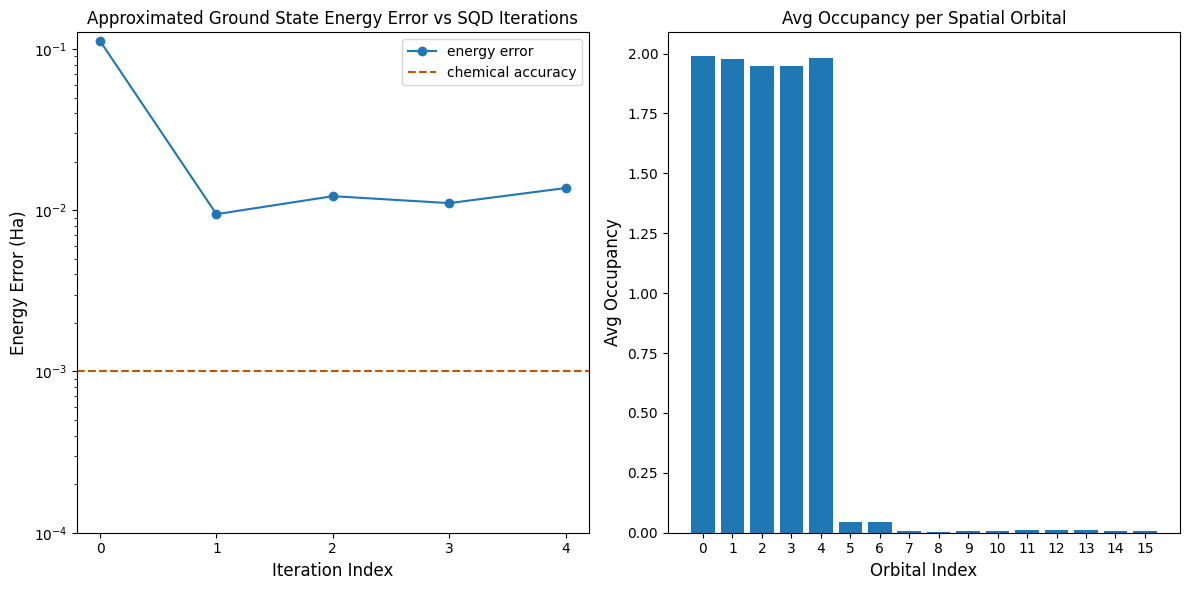

In [14]:
# Data for energies plot
x1 = range(iterations)
e_diff = [abs(np.min(energies) - exact_energy) for energies in e_hist]
yt1 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4]
 
# Chemical accuracy (+/- 1 milli-Hartree)
chem_accuracy = 0.001
 
# Data for avg spatial orbital occupancy
y2 = occupancy_hist[-1][0] + occupancy_hist[-1][1]
x2 = range(len(y2))
 
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
 
# Plot energies
axs[0].plot(x1, e_diff, label="energy error", marker="o")
axs[0].set_xticks(x1)
axs[0].set_xticklabels(x1)
axs[0].set_yticks(yt1)
axs[0].set_yticklabels(yt1)
axs[0].set_yscale("log")
axs[0].set_ylim(1e-4)
axs[0].axhline(
    y=chem_accuracy,
    color="#BF5700",
    linestyle="--",
    label="chemical accuracy",
)
axs[0].set_title("Approximated Ground State Energy Error vs SQD Iterations")
axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
axs[0].set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
axs[0].legend()
 
# Plot orbital occupancy
axs[1].bar(x2, y2, width=0.8)
axs[1].set_xticks(x2)
axs[1].set_xticklabels(x2)
axs[1].set_title("Avg Occupancy per Spatial Orbital")
axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})
 
plt.tight_layout()
plt.show()